In [ ]:
!pip install -q tensorflow==2.13.0 tensorflowjs==4.12.0 scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight


In [ ]:
print("TensorFlow version:", tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print("🚀 Using TPU")
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
    print("💻 Using GPU/CPU")


Found 1792 images belonging to 2 classes.
Found 641 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
train_dir = '/content/drive/MyDrive/data/train'        # ✅ Adjust if needed
val_dir = '/content/drive/MyDrive/data/validation'     # ✅ Adjust if needed


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='reflect'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("⚖️ Class Weights:", class_weights)


In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='swish')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

model.summary()


Epoch 1/3
448/448 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.8662 - loss: 0.4221 - val_accuracy: 0.6724 - val_loss: 0.7932
Epoch 2/3
448/448 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.8562 - loss: 0.4236 - val_accuracy: 0.6724 - val_loss: 0.8188
Epoch 3/3
448/448 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.8566 - loss: 0.4283 - val_accuracy: 0.6724 - val_loss: 0.9866


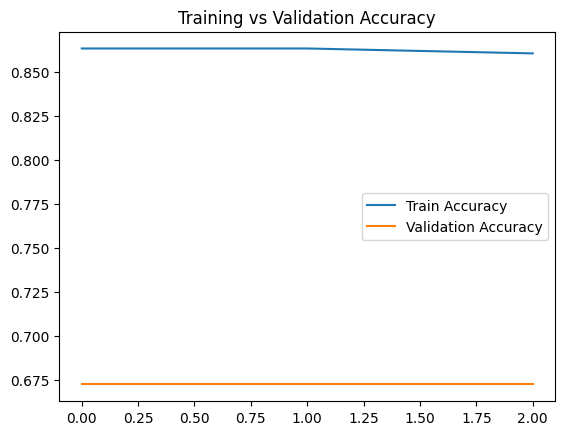

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/best_model.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)


In [ ]:
def plot_history(hist):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


NameError: name 'model' is not defined

In [ ]:
model.save('/content/final_model.keras')


In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    --quantize_float16 \
    /content/final_model.keras \
    /content/tfjs_model



🔥 Training complete!
✅ Model saved as 'models/final_model.keras'
✅ Class indices saved as 'models/class_indices.json'
✅ Accuracy plot saved as 'models/training_plot.png'


In [ ]:
import shutil
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

from google.colab import files
files.download('/content/tfjs_model.zip')
